# Sheet 3

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.optimize

### Question 1

In [5]:
x = np.random.uniform(-10, 10, size = 20)
x

array([ 1.51737252,  3.52791736,  0.86192719, -7.73827136,  5.66268032,
       -0.06978327,  8.82669488, -6.76916481, -7.92997818,  4.8012014 ,
       -4.74997601,  8.05841729,  5.90271526,  7.68398756,  7.18991045,
       -8.40713062,  0.21874273, -1.19232015, -2.61262668,  1.09034488])

95% conf: [3.68, 7.14]


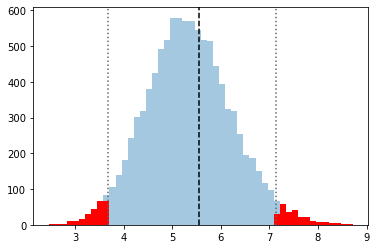

In [7]:
μhat = np.mean(x)
σhat = np.sqrt(np.mean((x-μhat)**2))

# resample x from N(μ̂, σ̂^2)
def rx_star(): return np.random.normal(loc=μhat, scale=σhat, size = len(x))

def σ_(data): return np.sqrt(np.mean((data-np.mean(data))**2))

# define readout statistic
σ_sample = np.array([σ_(rx_star()) for _ in range(10000)])

lo, hi = np.quantile(σ_sample, [.025, .975])
print(f'95% conf: [{lo:.3}, {hi:.3}]')

plt.hist(σ_sample, bins= 50, alpha=.4)
plt.hist(σ_sample[(σ_sample< lo) | (σ_sample >hi)], bins= 50, color='red')
plt.axvline(σhat, linestyle='--', color='black')
plt.axvline(lo, linestyle=':', color='0.4')
plt.axvline(hi, linestyle=':', color='0.4')
plt.show()


95% conf: [4.13, 6.47]


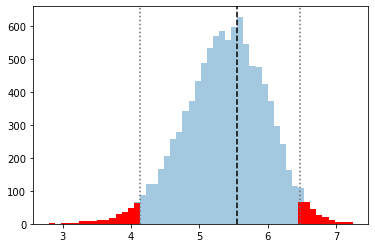

In [11]:
# non parametric sampling
def rx_star(): return np.random.choice(x, size=len(x))

def σ_(data): return np.sqrt(np.mean((data - np.mean(data))**2))

σ_sample = np.array([σ_(rx_star()) for _ in range(10000)])

lo, hi = np.quantile(σ_sample, [.025, .975])
print(f'95% conf: [{lo:.3}, {hi:.3}]')

plt.hist(σ_sample, bins= 50, alpha=.4)
plt.hist(σ_sample[(σ_sample< lo) | (σ_sample >hi)], bins= 50, color='red')
plt.axvline(σhat, linestyle='--', color='black')
plt.axvline(lo, linestyle=':', color='0.4')
plt.axvline(hi, linestyle=':', color='0.4')
plt.show()

### Question 2

In [126]:
x = [3,1,5]
y = [2,3]

Report a 95% confidence interval for $\hat{\nu} - \hat{\mu}$.

mle of parameters of $X \sim \text{Poisson}(\lambda)$: $\; \hat{\lambda} = \bar{X}$

95% conf: [-3.33, 2.5]


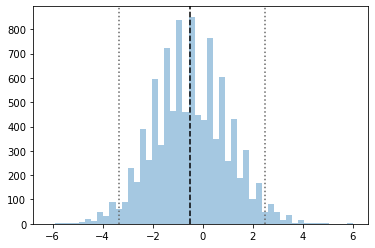

In [127]:
μhat = np.mean(x)
νhat = np.mean(y)

def rxy_star(): return np.random.poisson(lam=μhat, size=len(x)), np.random.poisson(lam=νhat, size=len(y))

def t(x, y): return np.mean(y) - np.mean(x)

t_ = np.array([t(*rxy_star()) for _ in range(10000)])
lo, hi = np.quantile(t_, [.025, .975])
print(f'95% conf: [{lo:.3}, {hi:.3}]')

plt.hist(t_, bins=50, alpha=.4)
plt.axvline(t(x,y), linestyle='--', color='black')
plt.axvline(lo, linestyle=':', color='0.4')
plt.axvline(hi, linestyle=':', color='0.4')
plt.show()

Null hypothesis $H_0$: $\mu = \nu$

p = 0.7974


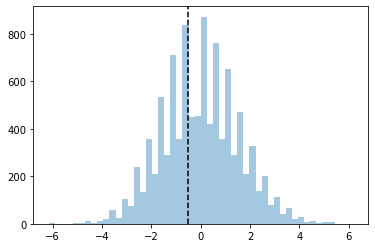

In [131]:
μhat = np.mean(np.concatenate([x, y]))

def rxy_star(): return np.random.poisson(lam=μhat, size=len(x)), np.random.poisson(lam=μhat, size=len(y))

def t(x, y): return np.mean(y) - np.mean(x)

t_ = np.array([t(*rxy_star()) for _ in range(10000)])

# two sided test: deviation of t from zero happens on both sides of zero
p = 2*min(np.mean(t_>=t(x,y)), np.mean(t_<=t(x,y)))
print(f'p = {p}')

plt.hist(t_, bins=50, alpha=.4)
plt.axvline(t(x,y), linestyle='--', color='black')
plt.show()

### Question 3

We start by recoding the model without using pandas hacks and binning with pandas.cut(*args).

In [103]:
climate = pd.read_csv('climate.csv')
climate = climate.loc[climate.station == 'Cambridge']
t = climate.yyyy + (climate.mm - 1)/12
temp = .5*(climate.tmin + climate.tmax)

$$ \text{temp} = \alpha + \beta_1\sin(2\pi t) + \beta_2\cos(2\pi t) + \gamma_u(t - 2000) + N(0, \sigma^2)\qquad u \in \text{decades}$$

In [104]:
t.min(), t.max()

(1959.0, 2020.5833333333333)

we might as well put 2020.5 in the last decade and 1959 in the 60's, since otherwise we don't have enough data to make reliable predictions about these confining decades.

In [105]:
t = t.astype(str).replace(to_replace= ['195\d\.?\d*','202\d\.?\d*'],value=[1960,2020], regex=True).astype(float)


In [106]:
# create bins [low,hi)
num_decades = int((t.max()-t.min())/10)
bins = np.array([(t.min()+10*(k-1), t.min()+10*k) for k in range(1, num_decades+1)])

In [107]:
one_hot = [np.where((t>= interval[0]) & (t< interval[1]),1,0) for interval in bins]

β1 = -1.0725956009319042
β2 = -6.1774543346446


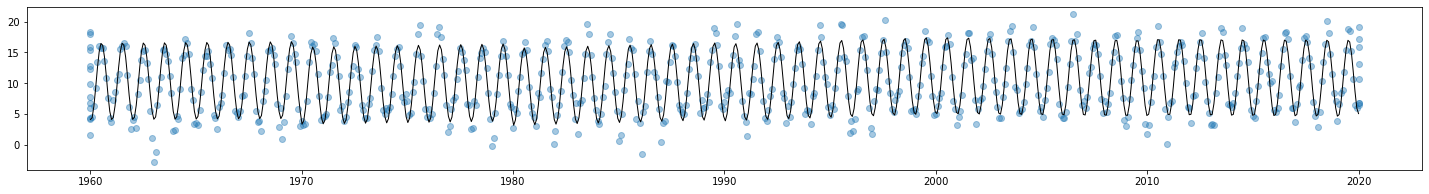

In [108]:
π = np.pi
X = np.column_stack([np.sin(2*π*t), np.cos(2*π*t)] + [γu*(t - 2000) for γu in one_hot])
model = sklearn.linear_model.LinearRegression()
model.fit(X,temp)
for i in range(2):
    print(f'β{i+1} = {model.coef_[i]}')
    
# plot a fit. Variables here will be used only for plotting.
newt = np.linspace(1960,2020, 60*12)
new_onehot = [np.where((newt>= interval[0]) & (newt< interval[1]),1,0) for interval in bins]
newX = np.column_stack([np.sin(2*π*newt), np.cos(2*π*newt)]\
                       + [γu*(newt - 2000) for γu in new_onehot])
temp_pred = model.predict(newX)

fig, ax = plt.subplots(figsize=(25,3))
ax.scatter(t, temp, alpha=.4)
ax.plot(newt, temp_pred, linestyle='solid', color='black', linewidth=1, zorder=4)
plt.show()

1980 (1980-90) is the third and 2010 (2010-20) is the last decade

95% confidence interval: [-0.18 -0.0444]


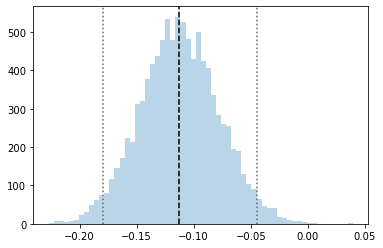

In [109]:
# define the the readout statistic on the given dataset
t_stat = model.coef_[-1] - model.coef_[-int((2020-1980)/10)]
pred = model.predict(X)
σhat = np.sqrt(np.mean((temp - pred)**2))
def r_temp(): return np.random.normal(loc=pred, scale=σhat)  #size already set by loc

# define the readout statistic as a function
def t_(x):
    m = sklearn.linear_model.LinearRegression()
    m.fit(X, x)
    return m.coef_[-1] - m.coef_[-int((2020-1980)/10)]

# sample the readout statistic and report its spread
t_sample = np.array([t_(r_temp()) for _ in range(10000)])
lo, hi = np.quantile(t_sample, [.025, .975])
print(f'95% confidence interval: [{lo:.3} {hi:.3}]')
plt.hist(t_sample, bins=60, alpha=.3)
plt.axvline(t_stat, linestyle='--', color='black')
plt.axvline(lo, linestyle=':', color='0.4')
plt.axvline(hi, linestyle=':', color='0.4')
plt.show()

Conclusions: The spread of the readout statistic t is tightly centered about zero. A 95% confidence interval is roughly between -0.18 and 0.05. There is good indication that the statistic is zero. However the greater value on the left suggests that $\gamma_{1980}$ might in fact be slightly larger, indicating a steeper temperature increase in the 1980's.

#### Hypotesis Testing

Null Hypothesis: $\; \gamma_{2010} = \gamma_{1980}$

The method to carry out this part is similar to the resampling above. The main point is to modify the one-hot vectors.

In [110]:
bins_sub = np.array([row for row in bins if (row[0]!=1980) and (row[0]!=2010)])
bins_80_10 =  np.array([row for row in bins if (row[0]==1980) or (row[0]==2010)])

In [111]:
bins_80_10

array([[1980., 1990.],
       [2010., 2020.]])

In [115]:
one_hot = [np.where((t>= interval[0]) & (t< interval[1]),1,0) for interval in bins_sub]\
+ [sum([np.where((t>= interval[0]) & (t< interval[1]),1,0) for interval in bins_80_10])]

p-value = 0.0012


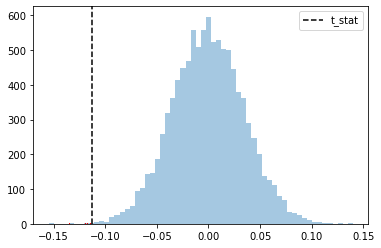

In [125]:
X = np.column_stack([np.sin(2*π*t), np.cos(2*π*t)] + [γu*(t - 2000) for γu in one_hot])
model = sklearn.linear_model.LinearRegression()
model.fit(X, temp)
pred=model.predict(X)
σhat = np.sqrt(np.mean((temp-pred)**2))

def r_temp(): return np.random.normal(loc=pred, scale=σhat)
t_stat = t_(temp)  # might as well save the value instead of calling t_ over and over
def t_(x):
    '''Fit a general model where γ1980 and γ2010 are not necessarily different'''
    one_hot = [np.where((t>= interval[0]) & (t< interval[1]),1,0) for interval in bins]
    X = np.column_stack([np.sin(2*π*t), np.cos(2*π*t)] + [γu*(t - 2000) for γu in one_hot])
    m = sklearn.linear_model.LinearRegression()
    m.fit(X,x)
    return m.coef_[-1] - m.coef_[-int((2020 - 1980)/10)]

# resample and plot two sided p values
t_sample = np.array([t_(r_temp()) for _ in range(10000)])
p = 2*min(np.mean(t_sample <= t_stat), np.mean(t_sample >= t_stat))
print(f'p-value = {p}')

plt.hist(t_sample, bins=60, alpha=.4)
plt.hist(t_sample[(t_sample<=np.quantile(t_sample,p/2))],
         color='r', bins=60)
plt.axvline(t_stat, linestyle='--', color='black', zorder=5, label='t_stat')
plt.legend()
plt.show()

<strong>Conclusions</strong>: We have a p-value close to zero. This tells us that according to the Null hypothesis model $H_0$ the probability to see a test statistic value as extreme as o more extreme than the one observed drom the data is very small, so we are led to reject the hypothesis that the rate of increase in temperature was the same in the 1980's as between 2010 and 2020. The previous analysis tells us that there was a steeper increase in temperature in the 80's. A further indicator of the fallacy of the model $H_0$ is the shift of the previous model to the left, i.e. towards more negative balues, an indication of the fact $\gamma_{1980} > \gamma_{2010}$.

### Question 4

In [1]:
def logPr(n, y, θ):
    return y*np.log(θ) + (n-y)*np.log(1 - θ)


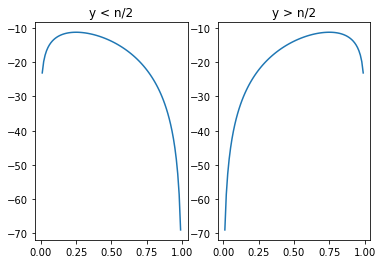

In [23]:
# y < n/2
θSample = np.linspace(0,1, 100)[1:-1]  # avoid divide by zero warning by excluding 0 and 1
fig, axs = plt.subplots(1,2)
ax1, ax2 = axs
ax1.plot(θSample, logPr(20, 5, θSample))
ax1.set_title('y < n/2')
ax2.plot(θSample, logPr(20, 15, θSample))
ax2.set_title('y > n/2')
plt.show()